# Analyzing results from a stock price prediction model with Python

## Goal
Understand the behavior and reliability of the predictions made by a Deep Neural Network model about Petrobras' (PETR4) stock price.

## The Datasets
There are predictions for the next 1, 7, 28, 91, 182 and 364 days. 
Each of these predictions were made by a model slightly different from one another, focusing in capture specific trends for each situation.

We have two datasets here (both from an excel source):

compilation_2025-01-18_predictions.xlsx | Version of the DNN model that was trained with data from January 1st, 2006 until December 31st, 2023. This model used data january 1st, 2024 until November 31st, 2024 to make predictions, the results of which will be analysed in this project.

compilation_2025-01-19_predictions.xlsx | Version of the DNN model that was trained with data from January 1st, 2006 until December 31st, 2022. This model used data january 1st, 2023 until November 31st, 2024 to make predictions, the results of which will be analysed in this project.


## Loading libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import seaborn as sns
import seaborn.objects as so
import statistics as st
import scipy.stats as stats
from scipy.stats import levene


# Database loading and data cleaning

### Database upload

In [2]:
#Load the databases

path_results = "./03 - Resultados"

db_series = os.listdir(path_results)

# Starts an empty DataFrame to store the data
df_results = pd.DataFrame()


for db in db_series:
    if db.endswith('.xlsx'):
        pathway = os.path.join(path_results, db)
        print(pathway)
        df_temp = pd.read_excel(pathway, sheet_name = "simulacoes")
        nome_primeira_coluna = df_temp.columns[0]
        
        df_temp["source"] = str(pathway)
        df_results = pd.concat([df_results, df_temp],ignore_index=True)
        


./03 - Resultados\compilation_2025-01-18_predictions.xlsx
./03 - Resultados\compilation_2025-01-19_predictions.xlsx


### Renaming columns

In [3]:
df_results = df_results.rename(columns ={"Date":"Predicted_date" 
                               ,"Dia base":"initial_date"
                               , "Prediction":"Predicted_close_price"
                               , "FECHAMENTO Dia BASE":"initial_date_close_price"
                               ,"Var. Preço prevista Dia base Vs Predição":"Var_closing_base_to_prediction"
                               ,"Var. Preço prevista Dia base Vs Real": "Var_real_closing_to_prediction"
                               ,"Acertou a direção?":"Right_direction?"
                               ,"FECHAMENTO REAL":"Real_closing"                                         
                               ,"Dif. Centavos":"predicted_diference"
                               ,"Simulação":"Simulation"})

df_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Simulation                        3276 non-null   object        
 1   initial_date                      3276 non-null   datetime64[ns]
 2   Predicted_date                    3276 non-null   datetime64[ns]
 3   Predicted_close_price             3276 non-null   float64       
 4   initial_date_close_price          3276 non-null   float64       
 5   Var_closing_base_to_prediction    3276 non-null   float64       
 6   Var_real_closing_to_prediction    3276 non-null   float64       
 7   Right_direction?                  3276 non-null   object        
 8   Dif. Centavos variação projetada  3276 non-null   float64       
 9   Var.                              0 non-null      float64       
 10  Real_closing                      3276 non-null 

### Dropping unnecessary columns

In [4]:
df_results = df_results.drop(["Dif. Centavos variação projetada","Acertou a direção?.1","Unnamed: 12","Var..1","Var."], axis = 1)
df_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Simulation                      3276 non-null   object        
 1   initial_date                    3276 non-null   datetime64[ns]
 2   Predicted_date                  3276 non-null   datetime64[ns]
 3   Predicted_close_price           3276 non-null   float64       
 4   initial_date_close_price        3276 non-null   float64       
 5   Var_closing_base_to_prediction  3276 non-null   float64       
 6   Var_real_closing_to_prediction  3276 non-null   float64       
 7   Right_direction?                3276 non-null   object        
 8   Real_closing                    3276 non-null   float64       
 9   Var. Preço prevista DoD         3272 non-null   float64       
 10  predicted_diference             3276 non-null   float64       
 11  sour

### Checking column names and data formats

In [5]:
df_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Simulation                      3276 non-null   object        
 1   initial_date                    3276 non-null   datetime64[ns]
 2   Predicted_date                  3276 non-null   datetime64[ns]
 3   Predicted_close_price           3276 non-null   float64       
 4   initial_date_close_price        3276 non-null   float64       
 5   Var_closing_base_to_prediction  3276 non-null   float64       
 6   Var_real_closing_to_prediction  3276 non-null   float64       
 7   Right_direction?                3276 non-null   object        
 8   Real_closing                    3276 non-null   float64       
 9   Var. Preço prevista DoD         3272 non-null   float64       
 10  predicted_diference             3276 non-null   float64       
 11  sour

### Checking the amount of simulations by model and source

In [6]:
df_results["Simulation"].value_counts()

Simulation
d_1      664
d_28     656
d_7      651
d_91     625
d_182    454
d_364    226
Name: count, dtype: int64

In [7]:
df_results["source"].value_counts()

source
./03 - Resultados\compilation_2025-01-19_predictions.xlsx    2256
./03 - Resultados\compilation_2025-01-18_predictions.xlsx    1020
Name: count, dtype: int64

### Creating dataframes for each kind of model and diferent dataframes to start the Data Analysis process

In [8]:
df_364 = df_results.loc[df_results["Simulation"]=="d_364"]
df_182 = df_results.loc[df_results["Simulation"]=="d_182"]
df_91 = df_results.loc[df_results["Simulation"]=="d_91"]
df_7 = df_results.loc[df_results["Simulation"]=="d_7"]
df_28 = df_results.loc[df_results["Simulation"]=="d_28"]
df_1 = df_results.loc[df_results["Simulation"]=="d_1"]

In [9]:
df_results_2022 = df_results.copy()
df_results_2023 = df_results.copy()

df_results_2022 = df_results_2022.loc[df_results_2022["source"] == "./03 - Resultados\compilation_2025-01-19_predictions.xlsx"]
df_results_2023 = df_results_2023.loc[df_results_2023["source"] == "./03 - Resultados\compilation_2025-01-18_predictions.xlsx"]

# 1st Analysis: Using boxplot to understand dispersion and the amount of outliers in each prediction 

<Axes: xlabel='predicted_diference', ylabel='Simulation'>

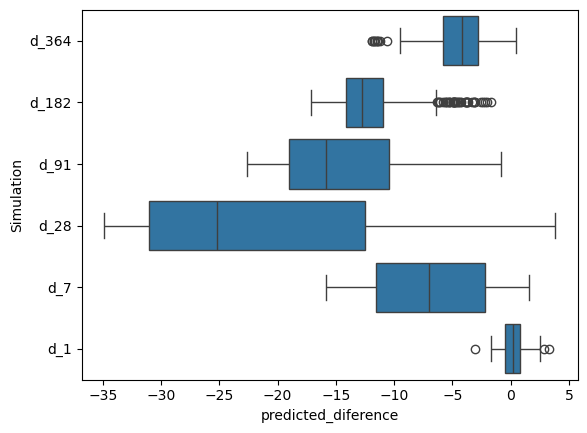

In [10]:
sns.boxplot(data=df_results_2022, x="predicted_diference", y="Simulation", order= ["d_364","d_182","d_91","d_28","d_7","d_1"])

<Axes: xlabel='predicted_diference', ylabel='Simulation'>

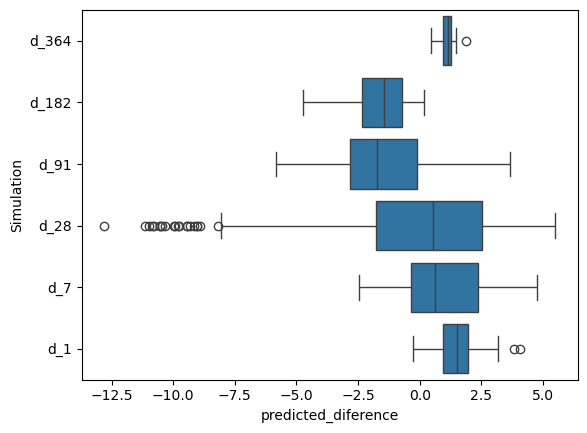

In [11]:
sns.boxplot(data=df_results_2023, x="predicted_diference", y="Simulation")

## Conclusion

The 2022 dataset has a bigger amount of outliers and a bigger difference between the maximum and minimum values of their predictions than the 2023 dataset.

Datasets D-1, d-364 and d-182 seem to be the ones more fit to a normal distribution of data. This may show that they are more reliable than the other models.

D-28 has the biggest difference between maximum and minimum values of their boxplots in both dataset, appearing to be the one that shows less reliable predictions in comparisson to other models.


# 2nd Analysis: Understanding the standard deviation and average values of the difference between the predicted and the real price for period

In [12]:
df_364_2023 = df_364.loc[df_364["source"] == "./03 - Resultados\compilation_2025-01-18_predictions.xlsx"]
print("df_364_2023")
print(st.stdev(df_364_2023["predicted_diference"]))
df_364_2022 = df_364.loc[df_364["source"] == "./03 - Resultados\compilation_2025-01-19_predictions.xlsx"]
print("df_364_2022")
print(st.stdev(df_364_2022["predicted_diference"]))

df_182_2023 = df_182.loc[df_182["source"] == "./03 - Resultados\compilation_2025-01-18_predictions.xlsx"]
print("df_182_2023")
print(st.stdev(df_182_2023["predicted_diference"]))
df_182_2022 = df_182.loc[df_182["source"] == "./03 - Resultados\compilation_2025-01-19_predictions.xlsx"]
print("df_182_2022")
print(st.stdev(df_182_2022["predicted_diference"]))

df_91_2023 = df_91.loc[df_91["source"] == "./03 - Resultados\compilation_2025-01-18_predictions.xlsx"]
print("df_91_2023")
print(st.stdev(df_91_2023["predicted_diference"]))
df_91_2022 = df_91.loc[df_91["source"] == "./03 - Resultados\compilation_2025-01-19_predictions.xlsx"]
print("df_91_2022")
print(st.stdev(df_91_2022["predicted_diference"]))

df_7_2023 = df_7.loc[df_7["source"] == "./03 - Resultados\compilation_2025-01-18_predictions.xlsx"]
print("df_7_2023")
print(st.stdev(df_7_2023["predicted_diference"]))
df_7_2022 = df_7.loc[df_7["source"] == "./03 - Resultados\compilation_2025-01-19_predictions.xlsx"]
print("df_7_2022")
print(st.stdev(df_7_2022["predicted_diference"]))

df_28_2023 = df_28.loc[df_28["source"] == "./03 - Resultados\compilation_2025-01-18_predictions.xlsx"]
print("df_28_2023")
print(st.stdev(df_28_2023["predicted_diference"]))
df_28_2022 = df_28.loc[df_28["source"] == "./03 - Resultados\compilation_2025-01-19_predictions.xlsx"]
print("df_28_2022")
print(st.stdev(df_28_2022["predicted_diference"]))

df_1_2023 = df_1.loc[df_1["source"] == "./03 - Resultados\compilation_2025-01-18_predictions.xlsx"]
print("df_1_2023")
print(st.stdev(df_1_2023["predicted_diference"]))
df_1_2022 = df_1.loc[df_1["source"] == "./03 - Resultados\compilation_2025-01-19_predictions.xlsx"]
print("df_1_2022")
print(st.stdev(df_1_2022["predicted_diference"]))


df_364_2023
0.394074847024916
df_364_2022
2.5942133840644703
df_182_2023
1.3008648935533746
df_182_2022
3.4510049481896576
df_91_2023
2.080842610143839
df_91_2022
5.434383107195464
df_7_2023
1.6682500674862208
df_7_2022
4.963579539989571
df_28_2023
3.9109536742811692
df_28_2022
11.347883327102487
df_1_2023
0.7334727480198098
df_1_2022
0.8336494546785211


In [13]:
print("df_364_2023")
print((df_364_2023["predicted_diference"]).mean())
print("df_364_2022")
print((df_364_2022["predicted_diference"]).mean())

print("df_182_2023")
print((df_182_2023["predicted_diference"]).mean())
print("df_182_2022")
print((df_182_2022["predicted_diference"]).mean())

print("df_91_2023")
print((df_91_2023["predicted_diference"]).mean())
print("df_91_2022")
print((df_91_2022["predicted_diference"]).mean())

print("df_7_2023")
print((df_7_2023["predicted_diference"]).mean())
print("df_7_2022")
print((df_7_2022["predicted_diference"]).mean())

print("df_28_2023")
print((df_28_2023["predicted_diference"]).mean())
print("df_28_2022")
print((df_28_2022["predicted_diference"]).mean())

print("df_1_2023")
print((df_1_2023["predicted_diference"]).mean())
print("df_1_2022")
print((df_1_2022["predicted_diference"]).mean())


df_364_2023
1.1209186207164399
df_364_2022
-4.466421845901845
df_182_2023
-1.742642131420451
df_182_2022
-12.018084763789522
df_91_2023
-1.3743503249694253
df_91_2022
-14.45872159711926
df_7_2023
0.8653166208948407
df_7_2022
-7.003257612992226
df_28_2023
-0.11110844674589392
df_28_2022
-20.967481082998898
df_1_2023
1.4420393178391355
df_1_2022
0.17242283610899317


## Conclusion:
The predictions made by the model trained with the 2022 dataset show a bigger difference in real numbers when compared to the results of the model trained with 2023 dataset. This is shown by the higher mean and standard deviation observed in the previous analysis.

The only exception for this pattern happens in the D_1 predictions. In this case the predictions made by the model trained with data from 2022 has a smaller difference from real numbers than the other one.

# 3rd Analysis: Using Histograms to understand dispersion of the dataset

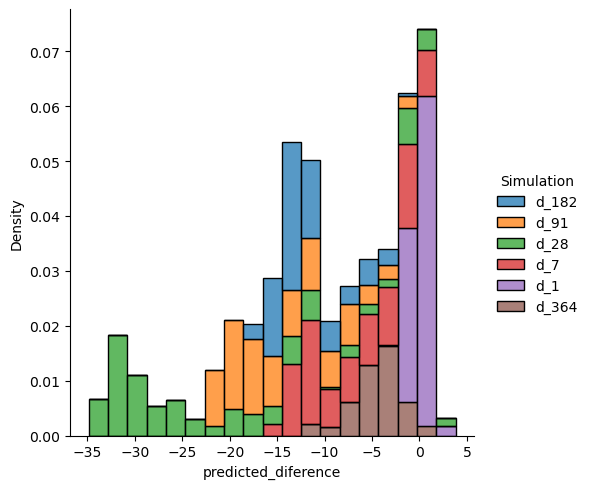

In [14]:
sns.displot(df_results_2022, x="predicted_diference",hue = "Simulation",multiple = "stack",stat="density")

## The histogram above shows the density of each column in the entire 2022 dataset
The greatest error is in the D_28 predictions, followed by the D_91 and D_182 in the sequence.
D_1 has the best accuracy, with D_364 having the second smallest error.

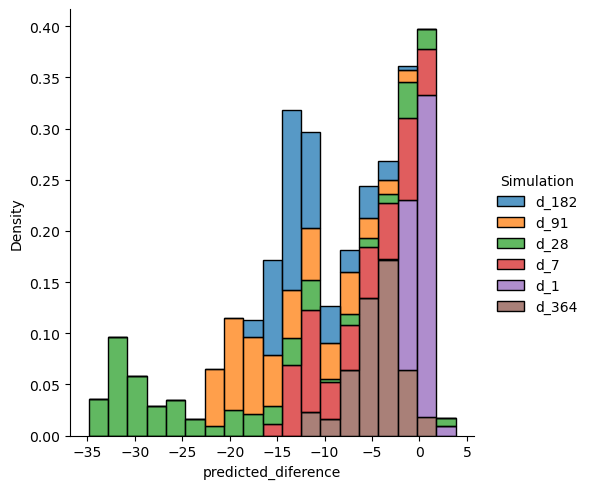

In [16]:
sns.displot(df_results_2022, x="predicted_diference",hue = "Simulation",multiple = "stack", stat="density", common_norm=False)

## The histogram above applies normalization to each subset. 
This treatment was used because the amount of predictions in the D_364 dataset is smaller than the other subsets. 
With this visualization the smaller subset can be better compared to other subsets.
This visualization makes it easier to see that the D_364 subset has a smaller error in comparison to another subsets

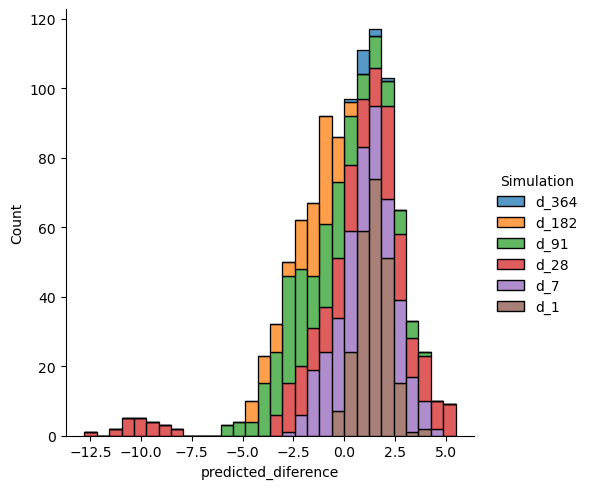

In [17]:
sns.displot(df_results_2023, x="predicted_diference",hue = "Simulation",multiple = "stack")

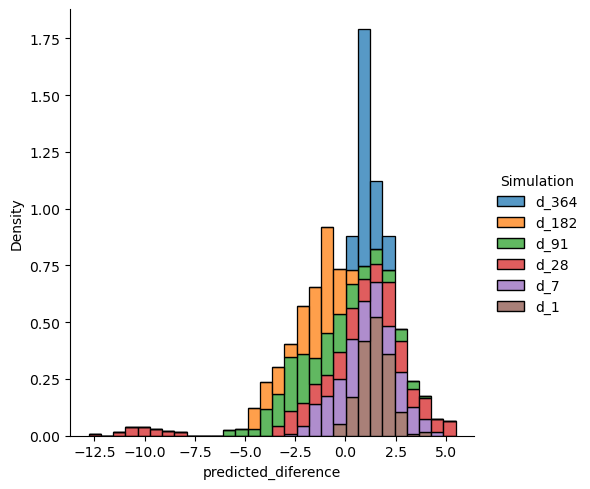

In [18]:
sns.displot(df_results_2023, x="predicted_diference",hue = "Simulation",multiple = "stack", stat="density", common_norm=False)

## The dataset of predictions using the model trained with data until the end of 2023 has shown a smaller distribution of errors.
D_1, D_7 and D_364 are closer to zero.

D_28 has shown some major mistakes in comparison to the other models.

# 4th Analysis: Predicted difference evolution with time

### Predicted difference Vs time for the entire dataset

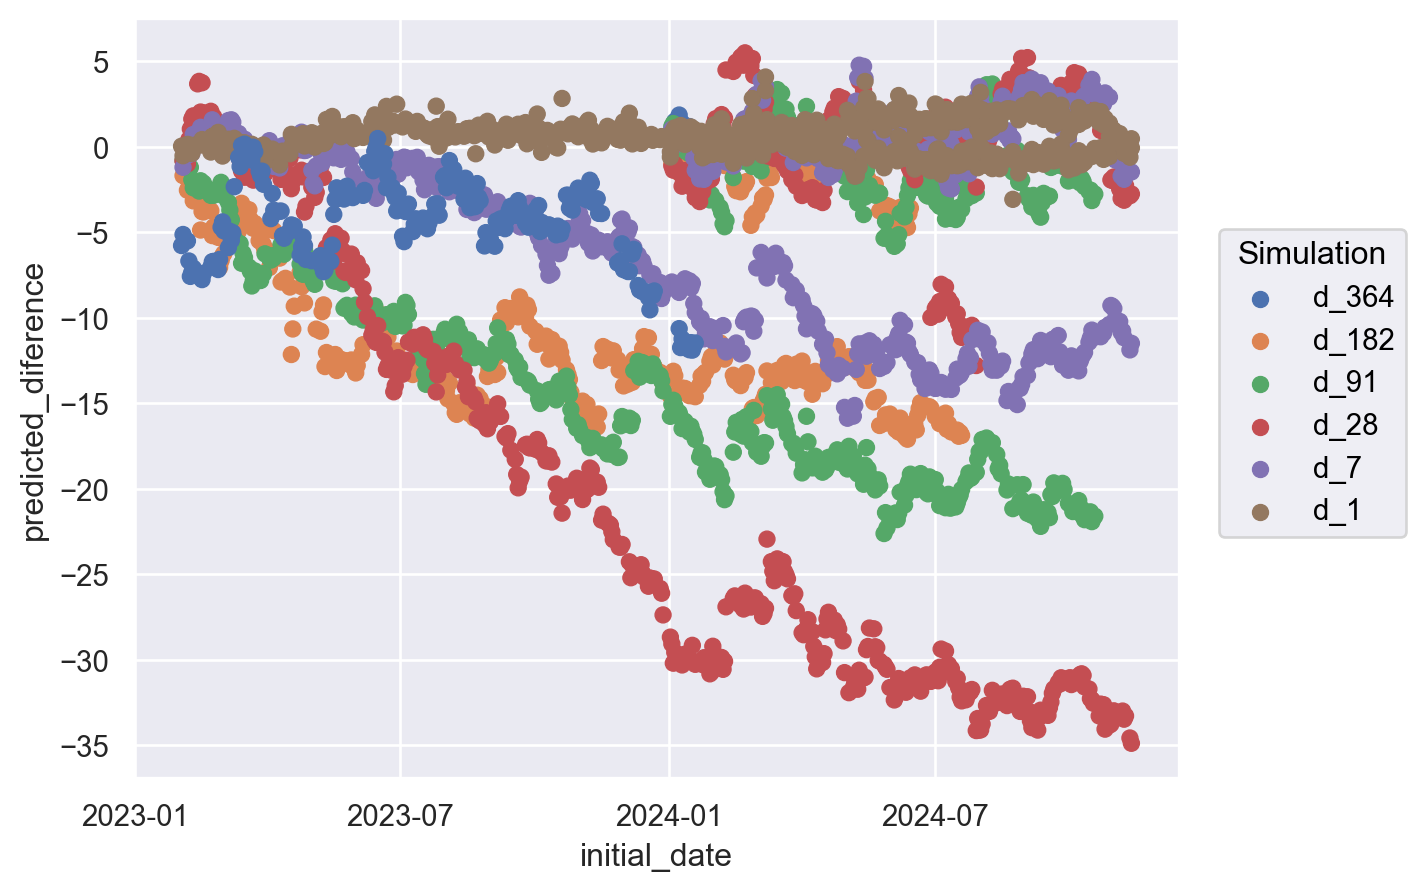

In [19]:
#2022 error dispersions
(
    so.Plot(
        df_results, x = "initial_date", y = "predicted_diference", color = "Simulation")
    .add(so.Dot())

)

### Predicted difference Vs time for the 2022 dataset

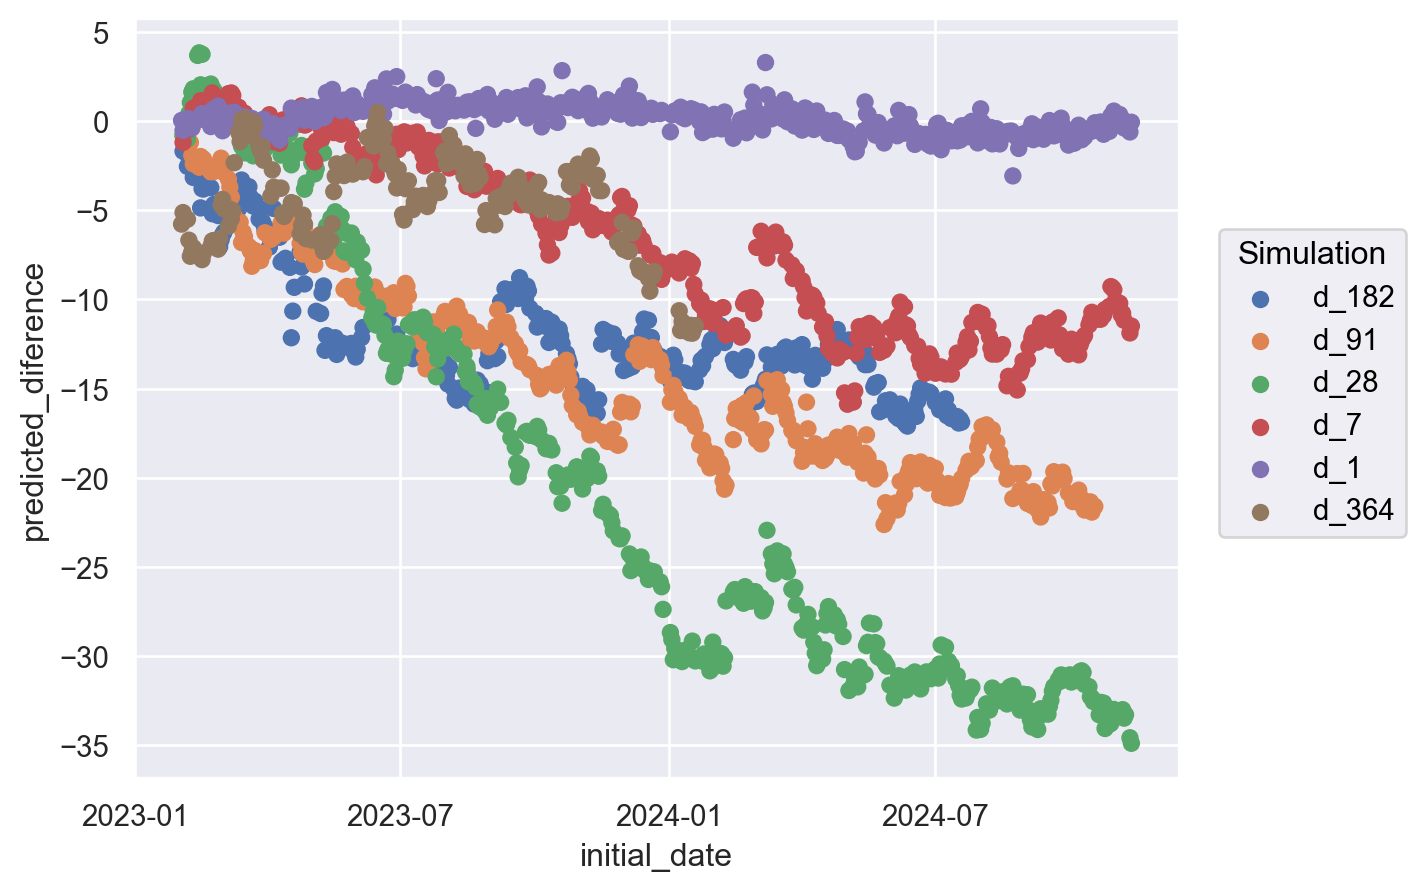

In [20]:
(
    so.Plot(
        df_results_2022, x = "initial_date", y = "predicted_diference", color = "Simulation")
    .add(so.Dot())

)

### Predicted difference Vs time for the 2023 dataset

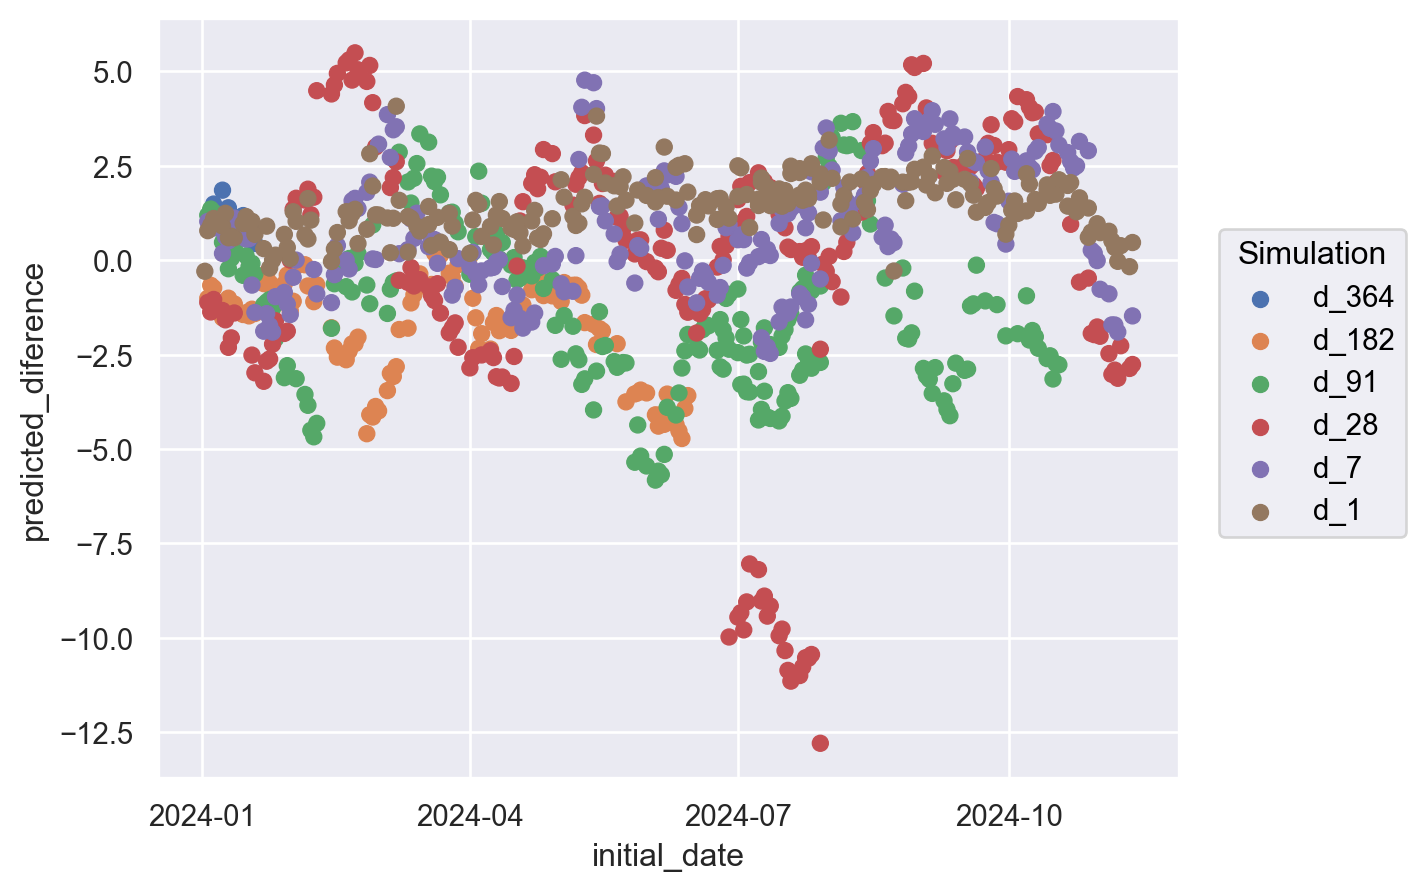

In [21]:
#2023 error dispersions

(
    so.Plot(
        df_results_2023, x = "initial_date", y = "predicted_diference", color = "Simulation")
    .add(so.Dot())

)

## Conclusion:
For the predictions that used trainning data until 2022, there is an error that gets worse as it gets more distant from the initial date of predictions.

The predicitions made with the model that had training data until the end of 2023 showed a significantly smaller error (Hypothesis test).

The 2022 predictions might have learned a trend that was not proven real after, while the 2023 predictions dataset got a better performance.


Predictions in the D_28 subset are innacurate and, as in other subsets, become worse as they get more distant from the original trained database.

Predictions for 91 and 182 days have a similar behaviour to the ones for 28 days, even though D_182 has a slightly better performance.


# 5th Analysis: Cumulative % of right guesses over time

### Data manipulation to create cumulative columns, viabilizing the analyses

In [34]:
df_results["right_prediction"] = (df_results["Right_direction?"] == "sim").astype(int)

# Ordening DataFrame through "serie" and "data"
df_results = df_results.sort_values(["Simulation", "source" , "initial_date"]).reset_index(drop=True)

# Creating columns with cummulative countings
df_results["simulations_until_this_day"] = df_results.groupby(["Simulation","source"]).cumcount() + 1
df_results["right_simulations_until_this_day"] = df_results.groupby(["Simulation","source"])["right_prediction"].cumsum()
df_results["%_right_guesses"] = (df_results["right_simulations_until_this_day"] / df_results["simulations_until_this_day"]) * 100


#Readapting the datasets with the new columns
df_results_2022 = df_results.copy()
df_results_2023 = df_results.copy()

df_results_2022 = df_results_2022.loc[df_results_2022["source"] == "./03 - Resultados\compilation_2025-01-19_predictions.xlsx"]
df_results_2023 = df_results_2023.loc[df_results_2023["source"] == "./03 - Resultados\compilation_2025-01-18_predictions.xlsx"]


In [35]:
df_results.head()

,Simulation,initial_date,Predicted_date,Predicted_close_price,initial_date_close_price,Var_closing_base_to_prediction,Var_real_closing_to_prediction,Right_direction?,Real_closing,Var. Preço prevista DoD,predicted_diference,source,right_prediction,simulations_until_this_day,right_simulations_until_this_day,_right_guesses,%_right_guesses
0,d_1,2024-01-02,2024-01-03,31.526073,30.855398,0.670675,0.963722,sim,31.819120,NaN,-0.293047,./03 - Resultados\compilation_2025-01-18_predi...,1,1,1,100.000000,100.000000
1,d_1,2024-01-03,2024-01-04,32.332703,31.819120,0.513582,-0.269514,não,31.549606,0.806629,0.783096,./03 - Resultados\compilation_2025-01-18_predi...,0,2,1,50.000000,50.000000
2,d_1,2024-01-04,2024-01-05,32.551880,31.549606,1.002274,0.073505,sim,31.623112,0.219177,0.928768,./03 - Resultados\compilation_2025-01-18_predi...,1,3,2,66.666667,66.666667
3,d_1,2024-01-05,2024-01-08,32.490971,31.623112,0.867859,-0.236847,não,31.386265,-0.060909,1.104706,./03 - Resultados\compilation_2025-01-18_predi...,0,4,2,50.000000,50.000000
4,d_1,2024-01-08,2024-01-09,32.023605,31.386265,0.637341,-0.269516,não,31.116749,-0.467365,0.906857,./03 - Resultados\compilation_2025-01-18_predi...,0,5,2,40.000000,40.000000


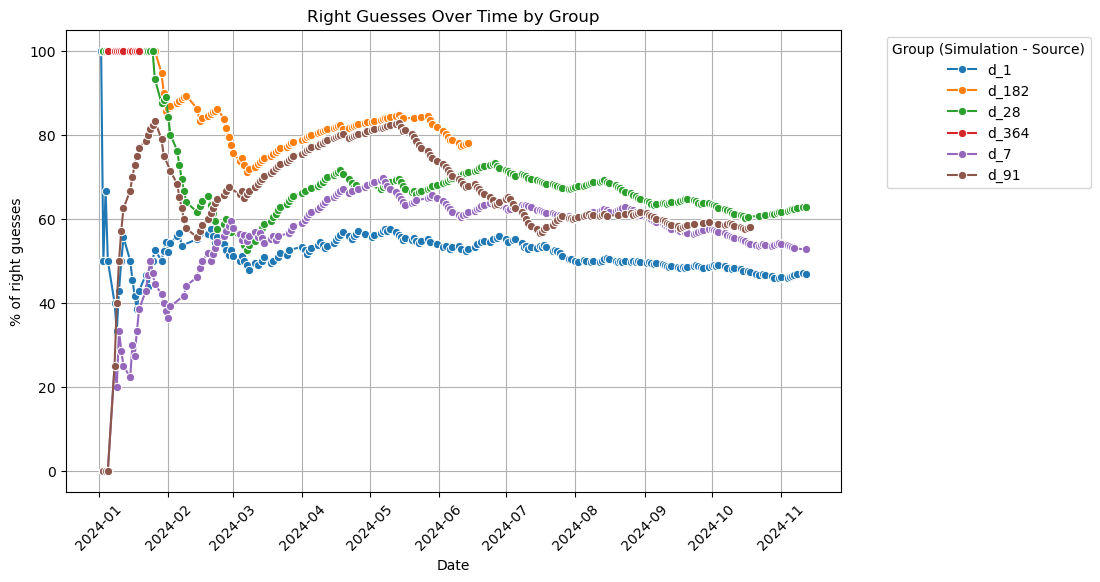

In [36]:
plt.figure(figsize=(10,6))

sns.lineplot(
    data = df_results_2023,
    x = "initial_date",
    y = "%_right_guesses",
    hue=df_results["Simulation"],
    marker = "o")

# Formatting the plot
plt.xlabel("Date")
plt.ylabel("% of right guesses")
plt.title("Right Guesses Over Time by Group")
plt.xticks(rotation=45)
plt.legend(title="Group (Simulation - Source)",
          bbox_to_anchor=(1.05, 1),  # Moves the legend to the right of the chart
            loc="upper left" )
plt.grid(True)

# Show the plot
plt.show()

In the model that uses dates until December 2023, the overall % of right guesses were better.

D_1 had the worst %, and has an overall better performance + higher vollatility.

D_182, D_91, D_28 and D_7 had a way better % of right guesses than in the 2022 dataset.

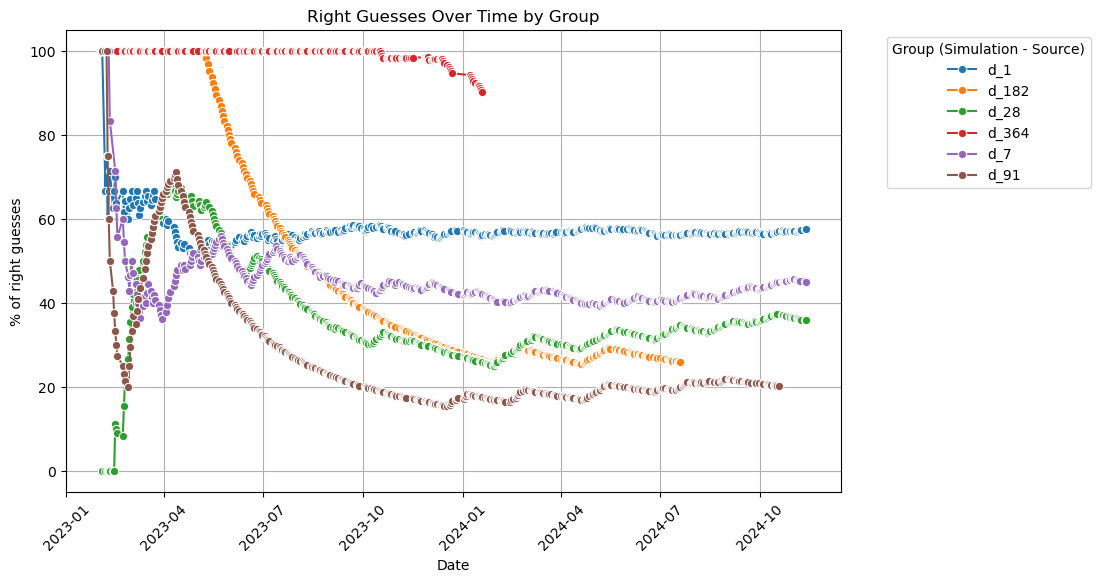

In [37]:
plt.figure(figsize=(10,6))

sns.lineplot(
    data = df_results_2022,
    x = "initial_date",
    y = "_right_guesses",
    hue=df_results["Simulation"],
    marker = "o")

# Formatting the plot
plt.xlabel("Date")
plt.ylabel("% of right guesses")
plt.title("Right Guesses Over Time by Group")
plt.xticks(rotation=45)
plt.legend(title="Group (Simulation - Source)",
          bbox_to_anchor=(1.05, 1),  # Moves the legend to the right of the chart
            loc="upper left" )
plt.grid(True)

# Show the plot
plt.show()

D-364 and d_1 are the most reliable models. D_1 is highly reliable for the first 4 months of predictions and D_364 for the first 10 months.

For the 2022 dataset, the percentage of correct guesses falls after 6 months on all models except for D1 and D364. 
D364 has its first error after 10 months and start missing guesses more frequently in December 2023. 
D1 has an accuracy of over 60% in the first three months.






## Conclusion

D_364 and D_1 are the most reliable models by: 
    
    1) bringing good percentages os right guesses in both models
    2) having a small mean and standard deviation values 
    
D_7 and D_182 have good mean and standard deviation numbers in the predicted vs real values with a good % of right guesses with the 2023 dataset


# 6th Analysis: Hypothesis test

Do a Hypothesis test where:

H0: The predicteed difference of the 2022 and 2023 datasets have the same variation.

H1: The variation of the predicteed difference of the 2023 dataset is smaller than the variation from the 2022 one.

But before doing the hypothesis test, we need to understand if the data has a normal distribution in both datasets, because this impacts directly our decision to choose what statistical method to use.

In [26]:
stats.normaltest(df_results_2022['predicted_diference'])

NormaltestResult(statistic=174.04026444210126, pvalue=1.6130088934291204e-38)

In [27]:
stats.normaltest(df_results_2023['predicted_diference'])

NormaltestResult(statistic=257.046920215022, pvalue=1.5239491646139034e-56)

In both tests to verify if the data is in a normal distribution, we've seen that the p value is higher than 0.05, showing that we must accept the hypothesis that both aren't a normal distribution.

In this situation a Levene's hypothesis test is the most recommendable to be applied, with the F test not being recommendable for datasets that aren't a normal distribution.

In [28]:
stat, p = levene(df_results_2023['predicted_diference'], df_results_2022['predicted_diference'])
print(f"Levene's test p-value: {p:.4f}")

Levene's test p-value: 0.0000


The p_value of 0 in this one sided hypothesis test shows that we should accept the alternative hypothesys (H1), that the variation of the 2023 dataset is lower than the 2022 one

# Analysis conclusion

The most reliable predictions are the ones for the next day (D_1) and for the next year (D_364), with the best results being present in the model trained with data from 2006 until the end of 2023. This conclusion is based on:

    - D_1 and D_364 having the smaller means and standard deviations in the diference from the predicted and real observed price
    - Smaller interquatile range and outliers for those predictions
    - Hypothesys test proved the smaller standard deviation of the 2023 dataset over the 2022

It was observed a relation in which the bigger it is the gap between the predicted date and the last day of the dataset used to train the model, the worse the error of the prediction to the real price gets. We can't forget that it was a situational simulation to see the results of the predictions for all the days of the year. In the real Life situation it would always use the most up to date info, reducing this risk noted on the study.